### Exploratory Data Analysis of The Transformed Loan Payments Table

In [1]:
# Import necessary modules

from data_frame_info import DataFrameInfo

from db_connector import open_latest_table


In [2]:
# Call the open_latest_table function and retrieve the final transformed loan payments dataframe.
loan_payments = open_latest_table()

In [3]:
# Call the DataFrameInfo class
table_info = DataFrameInfo(loan_payments)

# Calculate percentage loans recovered against total loans and total loan investments.
loan_recoveries = table_info.recovered_loans()

The proportion of loan investments recovered is 99.99%.
The proportion of whole loans recovered is 99.99%.
6 months of customer instalments will result in 18.14% loan recovery.


### Plot the percentage loan recoveries.

[99.99, 99.99, 18.14]


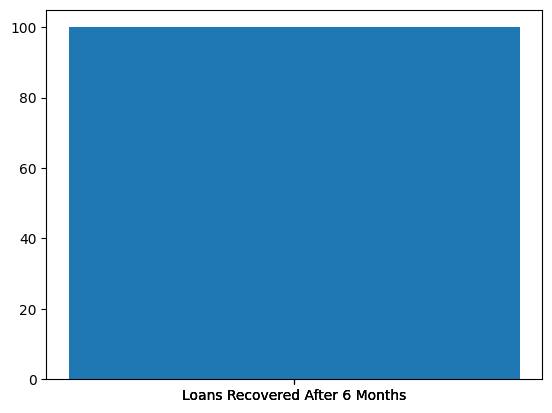

In [8]:
import matplotlib.pyplot as plt

categories = list(loan_recoveries.keys())
percentages = list(loan_recoveries.values())
print(percentages)
plt.bar(100, percentages, tick_label=categories)
plt.show()